In [1]:
import pandas as pd
import numpy as np
import math
from datetime import date
from alibi_detect.cd import TabularDrift
from alibi_detect.cd import ClassifierDrift
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [2]:
#Data import: use delta lake in databricks version
df = pd.read_csv(r"D:/GitHubLocal/NHL-Game-II/Period_1_Game_Stats_Final_ModelReady(April-10th-2022).csv")

In [3]:
df.dtypes

won                        int64
Shots                    float64
Shots_Against            float64
Goals                    float64
Goals_Against            float64
Takeaways                float64
Takeaways_Against        float64
Hits                     float64
Hits_Against             float64
Blocked Shots            float64
Blocked Shots Against    float64
Giveaways                float64
Giveaways_Against        float64
Missed Shots             float64
Missed Shots_Against     float64
Penalities               float64
Penalities_Against       float64
#Won Faceoffs            float64
#Lost Faceoffs           float64
HoA_away                   int64
HoA_home                   int64
dtype: object

In [4]:
df.head()

,won,Shots,Shots_Against,Goals,Goals_Against,Takeaways,Takeaways_Against,Hits,Hits_Against,Blocked Shots,...,Giveaways,Giveaways_Against,Missed Shots,Missed Shots_Against,Penalities,Penalities_Against,#Won Faceoffs,#Lost Faceoffs,HoA_away,HoA_home
0,0,8.0,8.0,0.0,3.0,1.0,3.0,14.0,5.0,3.0,...,6.0,7.0,4.0,0.0,1.0,1.0,10.0,12.0,1,0
1,1,8.0,8.0,3.0,0.0,3.0,1.0,5.0,14.0,3.0,...,7.0,6.0,0.0,4.0,1.0,1.0,12.0,10.0,0,1
2,1,11.0,12.0,0.0,1.0,0.0,2.0,4.0,4.0,6.0,...,2.0,0.0,6.0,3.0,1.0,3.0,11.0,9.0,1,0
3,0,12.0,11.0,1.0,0.0,2.0,0.0,4.0,4.0,8.0,...,0.0,2.0,3.0,6.0,3.0,1.0,9.0,11.0,0,1
4,1,9.0,8.0,0.0,1.0,3.0,2.0,4.0,5.0,7.0,...,7.0,5.0,3.0,8.0,2.0,1.0,7.0,11.0,1,0


In [5]:
def split_ref_new(df, last_n, include_target:bool = False):
    """
    Splits the main dataframe into a reference and new dataframe and np.array for drift detection
    If include_target is True, also returns split y
    """
    if include_target == False:
        X_ref = np.array(df.iloc[:-last_n, 1:])
        df_ref = df.iloc[:-last_n, 1:]
        X_new = np.array(df.iloc[-last_n:, 1:])
        df_new = df.iloc[-last_n:, 1:]

        return X_ref, df_ref, X_new, df_new
    
    if include_target == True:
        X_ref = np.array(df.iloc[:-last_n,:])
        df_ref = df.iloc[:-last_n,:]
        y_ref = df.iloc[:-last_n,0]

        X_new = np.array(df.iloc[-last_n:,:])
        df_new = df.iloc[-last_n:,:]
        y_new = df.iloc[-last_n:,0]

        return X_ref, df_ref, y_ref, y_ref, X_new, df_new, y_new


In [6]:
def plot_features(new_data, ref_data, feature_drift, drift_stats):
    """
    Plots the distribution of features in 4x... grid
    Need to add legend detailing blue = reference, red = last 60 rows
    """
    n_cols = 4
    n_rows = math.ceil((len(ref_data.columns)/4))
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    
    axs = axs.ravel()
    binwidth = 1
    for i in range(len(ref_data.columns)):
        bins = int((ref_data.iloc[:,i].max() - ref_data.iloc[:,i].min())/binwidth)
        ref_data.iloc[:,i].plot(kind="density", ax=axs[i], alpha=0.5, color="blue", bw_method='silverman')
        new_data.iloc[:,i].plot(kind="density", ax=axs[i], alpha=0.5, color="red", bw_method='silverman')
        
        axs[i].set_title(f'Distribution: {ref_data.columns[i]} - Drift: {feature_drift[i]}')
        
        axs[i].text(0.5,-0.2, f"K-S: {drift_stats[i][0]:.3f} -- pval: {drift_stats[i][1]:.3f}", size=12, ha="center", 
         transform=axs[i].transAxes)
    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.5)

In [7]:
def feature_KS_test(df, last_n):
    """
    Takes dataframe as input, runs a TabularDrift test, prints out results and outputs graphs
    """

    #Split dataset into references
    X_ref, df_ref, X_new, df_new = split_ref_new(df, last_n)
    
    #Get the feature names
    feature_names = df_ref.columns
    
    #TabularDrift: K-S tests for num features, Chi-squared for categorical
    cd = TabularDrift(p_val=0.05, x_ref = X_ref)
    
    #Predict general drift
    preds = cd.predict(X_new, return_p_val=True, return_distance = True)
    labels = ['No!', 'Yes!']
    print('General Drift Detected? {}'.format(labels[preds['data']['is_drift']]))
    print("\n")
    
    
    #Predict the drift for each feature
    fpreds = cd.predict(X_new, drift_type="feature", return_p_val=True, return_distance=True)
    
    #Get drift per feature
    feature_drift = []
    drift_stats = []
    for f in range(cd.n_features):
        stat = 'K-S'
        fname = feature_names[f]
        is_drift = fpreds['data']['is_drift'][f]
        stat_val, p_val = fpreds['data']['distance'][f], fpreds['data']['p_val'][f]
        print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')
        feature_drift.append(labels[is_drift])
        drift_stats.append([stat_val, p_val])
        
    #Plot feature distribs
    plot_features(df_new, df_ref, feature_drift, drift_stats)
    
    return drift_stats 

General Drift Detected? Yes!


Shots -- Drift? No! -- K-S 0.105 -- p-value 0.211
Shots_Against -- Drift? No! -- K-S 0.062 -- p-value 0.825
Goals -- Drift? No! -- K-S 0.067 -- p-value 0.736
Goals_Against -- Drift? No! -- K-S 0.031 -- p-value 1.000
Takeaways -- Drift? No! -- K-S 0.075 -- p-value 0.600
Takeaways_Against -- Drift? No! -- K-S 0.073 -- p-value 0.643
Hits -- Drift? Yes! -- K-S 0.219 -- p-value 0.000
Hits_Against -- Drift? Yes! -- K-S 0.249 -- p-value 0.000
Blocked Shots -- Drift? No! -- K-S 0.040 -- p-value 0.995
Blocked Shots Against -- Drift? No! -- K-S 0.133 -- p-value 0.054
Giveaways -- Drift? No! -- K-S 0.062 -- p-value 0.812
Giveaways_Against -- Drift? No! -- K-S 0.082 -- p-value 0.486
Missed Shots -- Drift? No! -- K-S 0.036 -- p-value 0.999
Missed Shots_Against -- Drift? No! -- K-S 0.104 -- p-value 0.223
Penalities -- Drift? No! -- K-S 0.065 -- p-value 0.773
Penalities_Against -- Drift? No! -- K-S 0.085 -- p-value 0.451
#Won Faceoffs -- Drift? No! -- K-S 0.115 -- p-val

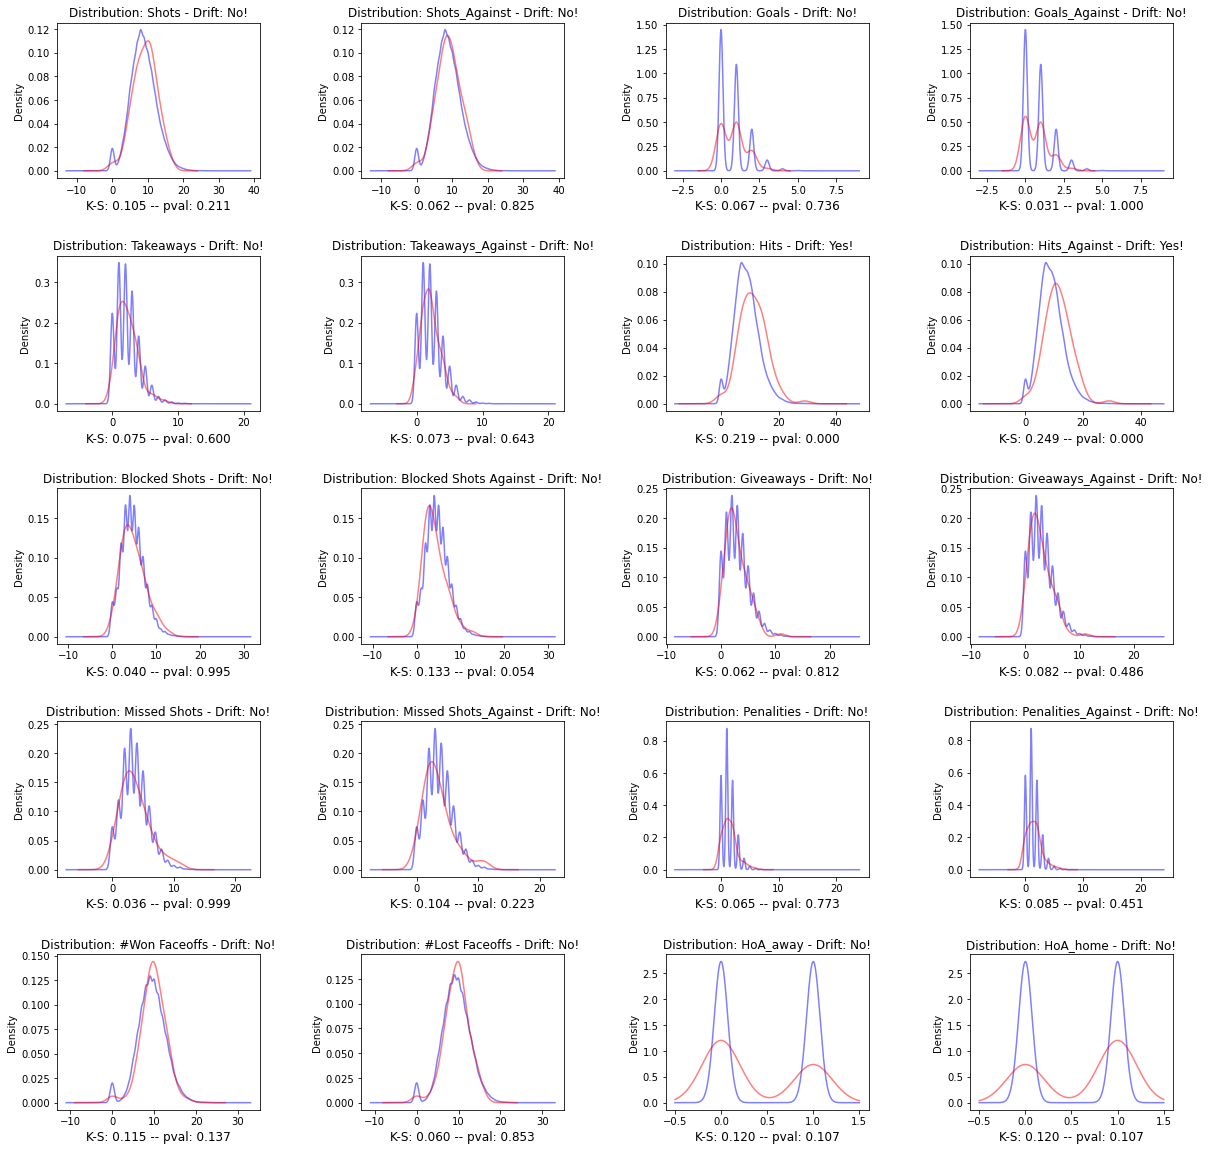

In [9]:
#Run TabularDrift detection for last 100 games
ks_drift_stats = feature_KS_test(df, 100)

In [11]:
#Store results into dataset
#Date, feature drift, score and pvalue
#First create dataframe, will change to append to existing delta lake dataframe
ks_drift_df = pd.DataFrame(columns = ["Date"] + [f"{col} Drift" for col in df.drop("won",axis=1).columns] + [f"{col} Score" for col in df.drop("won",axis=1).columns] + [f"{col} pval" for col in df.drop("won",axis=1).columns])

In [12]:
#Manipulate data into single list to add to dataframe
ks_scores, ks_pval = list(map(list, zip(*ks_drift_stats)))
ks_dummy_drift = [0 if pval > 0.05 else 1 for pval in ks_pval]
drift_list = [date.today()] + ks_dummy_drift + ks_scores + ks_pval

In [13]:
ks_drift_df.loc[len(ks_drift_df)] = drift_list

In [14]:
ks_drift_df

,Date,Shots Drift,Shots_Against Drift,Goals Drift,Goals_Against Drift,Takeaways Drift,Takeaways_Against Drift,Hits Drift,Hits_Against Drift,Blocked Shots Drift,...,Giveaways pval,Giveaways_Against pval,Missed Shots pval,Missed Shots_Against pval,Penalities pval,Penalities_Against pval,#Won Faceoffs pval,#Lost Faceoffs pval,HoA_away pval,HoA_home pval
0,2022-04-18,0,0,0,0,0,0,1,1,0,...,0.811993,0.48635,0.998829,0.222637,0.77307,0.451042,0.136643,0.853252,0.106852,0.106852


In [16]:
#Pearson correlation between features and target
#Split df into ref and new
X_ref, df_ref, y_ref, y_ref, X_new, df_new, y_new = split_ref_new(df, 50, include_target=True)

In [41]:
#Get correlation for ref
corr_ref = df_ref.drop("won", axis=1).corrwith(df_ref["won"])
corr_new = df_new.drop("won", axis=1).corrwith(df_new["won"])

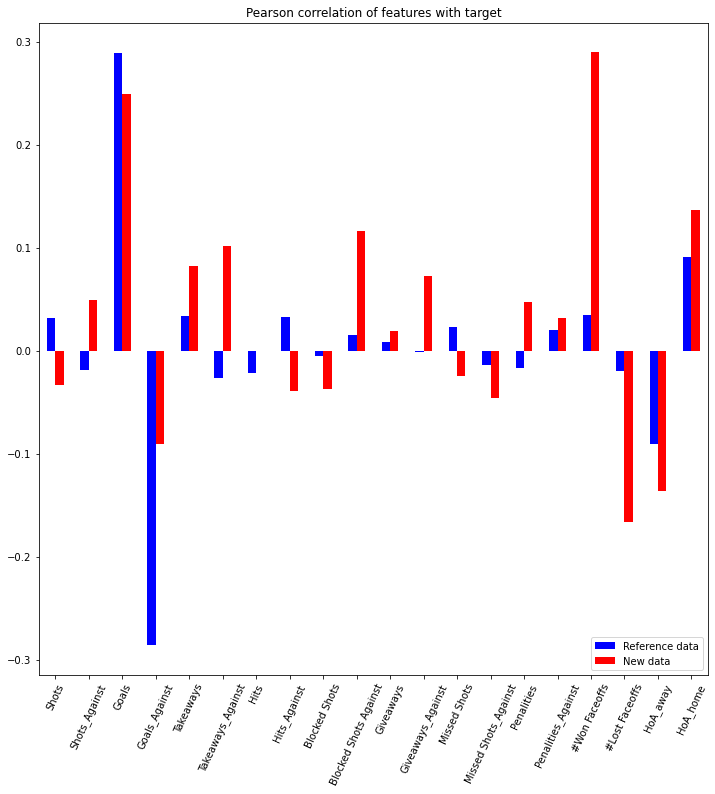

In [54]:
df_concat = pd.concat([corr_ref.rename('Reference data'), corr_new.rename('New data')], axis=1)
df_concat.plot.bar(rot=65, color=['blue', 'red'], figsize=(12,12))

plt.title("Pearson correlation of features with target")
plt.show()